# Телеком — Определение неэффективных операторов
<br>


**Описание проекта**<br>
Телеком провайдер «Нупозвони» хочет помочь своим клиентам (колл-центрам) найти неэффективных операторов и предложить новый сервис для регулярного мониторинга.<br>

**Цель исследования**<br>
Помочь «Нупозвони» найти самых неэффективных операторов.<br>
Признаки низкой эффективности:
  - много пропущенных входящих вызовов,
  - долгое ожидания ответа при входящих внешних вызовах,
  - мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков.<br>

**Описание доступных данных**<br>
Есть 2 датасета: 
1. `telecom_clients.csv` - содержит данные об использовании услуг «Нупозвони» — провайдера виртуальный телефонии.<br>
Его клиенты — колл-центры, которые: 
  - распределяют входящие вызовы на операторов,
  - совершают исходящие вызовы силами операторов.
  <br>


2. `telecom_dataset.csv` - таблица с данными о звонках операторов колл-центров<br> (операторы могут делать внутренние вызовы —  вызовы друг между другом внутри сети виртуальной телефонии).

**Ход исследования**<br>
1. Откроем оба файла с данными и изучим общую информацию,
<br>

2. Проведем предобработку данных, подготовим их к анализу (поработаем с дубликатами, пропусками, типами данных, названиями столбцов и т.п.),
<br>

3. Проведем исследовательский анализ данных:
 - определим специализации колл-центров: 
     - только на приём входящих звонков, 
     - только обзвоны - исходящие звонки,
     - совместные - оба типа сразу,
 - выясним длительность исследуемого периода наших данных,
 - посчитаем количество операторов у клиентов.
<br>

 
4. Определим неэффективных операторов. <br>
Снова распределим на 3 категории (в зависимости от количества пропущенных входящих, длительности ожидания ответа и количества исходящих - для "обзванивающих" колл-центров): высокая, средняя и низкая эффективность.
<br>

5. Проверим статистические гипотезы, есть ли статистически значимая разница, основанная на:
  - различиях тарифных планов операторов по времени ожидания входящего звонка в зависимости от тарифного плана, 
  - зависимости количества звонков от загрузки в разные дни недели.
  <br>


6. Суммируем все выводы и подготовим наглядную презентацию для заказчиков.

### Обзор данных

In [2]:
# Импортируем нужные библиотеки для чтения файлов, построения графиков и проведения расчетов

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math as mth
import seaborn as sns
from scipy import stats as st
import scipy
from datetime import timedelta
import datetime as dt
from plotly import graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Загрузим файлы

clients = pd.read_csv('/datasets/telecom_clients.csv')
dataset = pd.read_csv('/datasets/telecom_dataset.csv')

Начнём с файла 'clients':

In [4]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [5]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [6]:
# Проверим на дубликаты:
clients.duplicated().sum()

0

В датасете три колонки:

- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `tariff_plan` — Текущий тарифный план клиента
- `date_start` — Дата регистрации клиента в сервисе

Пропусков и дубликатов нет.<br>
В предобработке в колонке "date_start" будет нужно поменять тип данных на "дату".

Теперь файл 'dataset':

In [7]:
dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [9]:
dataset.duplicated().sum()

4900

В колонках файла `dataset' следующие данные:

- `user_id` — Идентификатор клиентского аккаунта колл-центра в сервисе
- `date` — Дата статистики
- `direction` — Направление вызовов (out - исходящий вызов, in — входящий вызов)
- `internal` — Является ли звонок внутренним звонком между операторами клиента
- `operator_id` — Идентификатор оператора
- `is_missed_call` — Является ли звонок пропущенным
- `calls_count` — Количество звонков
- `call_duration` — Длительность звонка (без учета времени ожидания)
- `total_call_duration` — Длительность звонка (с учетом времени ожидания)

Есть пропуски в столбцах 'operator_id' и 'internal'.<br>

После обработки пропусков будет нужно поменять типы данных в колонках:
 - 'date' на 'дату',
 - 'operator_id' - на целочисленные значения 'int' (после того, как разберёмся с пропусками: NaN невозможно перевести в int64),
 - 'internal' на 'bool'.
 
Также есть дубликаты.

### Предобработка данных

In [10]:
# Поменяем в колонке 'date_start' тип данных на 'дату'
clients['date_start'] = pd.to_datetime(clients['date_start'], format='%Y-%m-%d')

# Проверим
clients.info()
clients.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


**Теперь очередь файла 'dataset'.**<br>

Займёмся пропусками в столбце 'operator_id'

Цель нашего исследования - определить неэффективных операторов.<br>

В датасете у 8172 клиентов (15% от общего количества) нет 'operator_id', такие строки нам не помогут.<br>

У нас нет возможности восстановить их, не исказив результаты анализа, поэтому просто удалим пропущенные 
значения.

In [11]:
dataset.dropna(subset = ['operator_id'], inplace = True)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45730 entries, 1 to 53900
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              45730 non-null  int64  
 1   date                 45730 non-null  object 
 2   direction            45730 non-null  object 
 3   internal             45670 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       45730 non-null  bool   
 6   calls_count          45730 non-null  int64  
 7   call_duration        45730 non-null  int64  
 8   total_call_duration  45730 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.2+ MB


Остаётся столбец 'internal', пропущено 60 значений.

Аналогично, мы не можем быть уверены, является ли звонок внутренним звонком между операторами.<br>
Кроме того, 60 значений - совсем немного на фоне 45 тысяч, поэтому смело их удаляем.

In [12]:
dataset.dropna(subset = ['internal'], inplace = True)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45670 entries, 1 to 53900
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              45670 non-null  int64  
 1   date                 45670 non-null  object 
 2   direction            45670 non-null  object 
 3   internal             45670 non-null  object 
 4   operator_id          45670 non-null  float64
 5   is_missed_call       45670 non-null  bool   
 6   calls_count          45670 non-null  int64  
 7   call_duration        45670 non-null  int64  
 8   total_call_duration  45670 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.2+ MB


Отлично, пропусков не осталось.<br>

Теперь исправим типы данных:

In [13]:
# Столбец с датой
# заодно уберём ненужные нулевые значения времени, оставим только дату
dataset['date'] = pd.to_datetime(dataset['date'])
dataset['date'] = dataset['date'].dt.date
dataset['date'] = pd.to_datetime(dataset['date'])

# Поменяем тип на целочисленные значения 'int' 
dataset['operator_id'] = dataset['operator_id'].astype('int64')

# Исправим столбец 'internal'
dataset['internal'] = dataset['internal'].astype('bool')

# Проверим
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45670 entries, 1 to 53900
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              45670 non-null  int64         
 1   date                 45670 non-null  datetime64[ns]
 2   direction            45670 non-null  object        
 3   internal             45670 non-null  bool          
 4   operator_id          45670 non-null  int64         
 5   is_missed_call       45670 non-null  bool          
 6   calls_count          45670 non-null  int64         
 7   call_duration        45670 non-null  int64         
 8   total_call_duration  45670 non-null  int64         
dtypes: bool(2), datetime64[ns](1), int64(5), object(1)
memory usage: 2.9+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1,166377,2019-08-05,out,True,880022,True,3,0,5
2,166377,2019-08-05,out,True,880020,True,1,0,1
3,166377,2019-08-05,out,True,880020,False,1,10,18
4,166377,2019-08-05,out,False,880022,True,3,0,25
5,166377,2019-08-05,out,False,880020,False,2,3,29


In [14]:
# А что у нас теперь с дубликатами?

dataset.duplicated().sum()

4179

Много, почти 10% от общего числа строк, удаляем.

In [15]:
dataset.drop_duplicates(inplace = True)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41491 entries, 1 to 53899
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              41491 non-null  int64         
 1   date                 41491 non-null  datetime64[ns]
 2   direction            41491 non-null  object        
 3   internal             41491 non-null  bool          
 4   operator_id          41491 non-null  int64         
 5   is_missed_call       41491 non-null  bool          
 6   calls_count          41491 non-null  int64         
 7   call_duration        41491 non-null  int64         
 8   total_call_duration  41491 non-null  int64         
dtypes: bool(2), datetime64[ns](1), int64(5), object(1)
memory usage: 2.6+ MB


#### Вывод по предобработке

В файле 'clients' только поменяли тип данных на 'дату' в колонке 'date_start'.<br>

В файле 'dataset' изменений больше:

 - удалили строки с пропусками в столбцах 'operator_id' (15% от общего количества строк) и 'internal' (менее 1% от общего количества),
 - поменяли типы данных: 'date' на 'дату', 'operator_id' - на целочисленные значения 'int', 'internal' на 'bool',
 - удалили дубликаты (почти 10% от общего числа строк).

Названия столбцов не требуют исправлений в обоих файлах.<br>

Теперь можно приступать к исследовательскому анализу.

### Исследовательский анализ данных

Есть ощущение, что удобнее будет объединить данные двух файлов, чтобы не метаться от одного к другому.<br>
Пусть все данные будут в одном общем датафрейме.

In [16]:
# Объединённому датафрейму присвоим привычное название df
# Выберем режим объединения 'left', чтобы в результате слияния обязательно вошли все строки из левого датафрейма:

df = dataset.merge(clients, on='user_id', how='left')

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41491 entries, 0 to 41490
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              41491 non-null  int64         
 1   date                 41491 non-null  datetime64[ns]
 2   direction            41491 non-null  object        
 3   internal             41491 non-null  bool          
 4   operator_id          41491 non-null  int64         
 5   is_missed_call       41491 non-null  bool          
 6   calls_count          41491 non-null  int64         
 7   call_duration        41491 non-null  int64         
 8   total_call_duration  41491 non-null  int64         
 9   tariff_plan          41491 non-null  object        
 10  date_start           41491 non-null  datetime64[ns]
dtypes: bool(2), datetime64[ns](2), int64(5), object(2)
memory usage: 3.2+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-05,out,True,880022,True,3,0,5,B,2019-08-01
1,166377,2019-08-05,out,True,880020,True,1,0,1,B,2019-08-01
2,166377,2019-08-05,out,True,880020,False,1,10,18,B,2019-08-01
3,166377,2019-08-05,out,False,880022,True,3,0,25,B,2019-08-01
4,166377,2019-08-05,out,False,880020,False,2,3,29,B,2019-08-01


Отлично, дальше работаем с df.

#### Специализация колл-центров
Разделим колл-центры на 3 категории: 
 - на исходящих звонках, 
 - входящих, или
 - совместно входящих и исходящих.
 
Также посмотрим, каких больше.

In [17]:
# Создадим сводную таблицу по категориям
df_call_type_pivot = df.pivot_table(index=['tariff_plan','user_id','operator_id','date','calls_count'], 
    columns='direction', values='total_call_duration', aggfunc='sum').reset_index()

df_call_type_pivot.head()

direction,tariff_plan,user_id,operator_id,date,calls_count,in,out
0,A,166407,888532,2019-08-20,1,NaN,16.0
1,A,166407,888532,2019-08-26,1,22.0,NaN
2,A,166407,888532,2019-09-09,6,NaN,22.0
3,A,166407,888532,2019-09-10,2,242.0,NaN
4,A,166407,888532,2019-09-11,1,39.0,NaN


In [18]:
# Заменим NaN в сводной таблице на нули.
df_call_type_pivot = df_call_type_pivot.fillna(0)

# Заодно добавим столбцы с долями входящих и исходящих звонков,
# далее это пригодится чтобы посмотреть статистику длительности звонков операторов (в разбивке на входящие и исходящие вызовы)

df_call_type_pivot['call_in_%'] = df_call_type_pivot['in'] / (df_call_type_pivot['in'] + df_call_type_pivot['out']) * 100
df_call_type_pivot['call_out_%'] = df_call_type_pivot['out'] / (df_call_type_pivot['in'] + df_call_type_pivot['out']) * 100

Посмотрим на статистику распределения методом describe

In [19]:
df_call_type_pivot['in'].describe()

count    38378.000000
mean       280.091511
std        998.591990
min          0.000000
25%          0.000000
50%          0.000000
75%         89.000000
max      34280.000000
Name: in, dtype: float64

In [19]:
df_call_type_pivot['out'].describe()

count     38378.000000
mean       1150.388217
std        4930.296554
min           0.000000
25%           0.000000
50%          98.000000
75%         726.000000
max      166155.000000
Name: out, dtype: float64

In [20]:
# Проведём категоризацию по 75 % перцентилю
# Добавим новые столбцы в нашу сводную таблицу:

df_call_type_pivot['call_in'] = df_call_type_pivot['call_in_%'] >= 75
df_call_type_pivot['call_out'] = df_call_type_pivot['call_out_%'] >= 75

# Настроим отображение дробных чисел с двумя знаками после точки
pd.options.display.float_format='{:,.2f}'.format

df_call_type_pivot.head()

direction,tariff_plan,user_id,operator_id,date,calls_count,in,out,call_in_%,call_out_%,call_in,call_out
0,A,166407,888532,2019-08-20,1,0.00,16.00,0.00,100.00,False,True
1,A,166407,888532,2019-08-26,1,22.00,0.00,100.00,0.00,True,False
2,A,166407,888532,2019-09-09,6,0.00,22.00,0.00,100.00,False,True
3,A,166407,888532,2019-09-10,2,242.00,0.00,100.00,0.00,True,False
4,A,166407,888532,2019-09-11,1,39.00,0.00,100.00,0.00,True,False


In [21]:
# Ещё добавим столбец со смешанными вызовами
df_call_type_pivot['in_and_out_calls'] = 1 - df_call_type_pivot['call_in'] - df_call_type_pivot['call_out'] 

# Также, для однообразия поменяем значения False на 0, а True на 1.
df_call_type_pivot = df_call_type_pivot.replace(False, 0)   
df_call_type_pivot = df_call_type_pivot.replace(True, 1)    

df_call_type_pivot.head()

direction,tariff_plan,user_id,operator_id,date,calls_count,in,out,call_in_%,call_out_%,call_in,call_out,in_and_out_calls
0,A,166407,888532,2019-08-20,1,0.00,16.00,0.00,100.00,0,1,0
1,A,166407,888532,2019-08-26,1,22.00,0.00,100.00,0.00,1,0,0
2,A,166407,888532,2019-09-09,6,0.00,22.00,0.00,100.00,0,1,0
3,A,166407,888532,2019-09-10,2,242.00,0.00,100.00,0.00,1,0,0
4,A,166407,888532,2019-09-11,1,39.00,0.00,100.00,0.00,1,0,0


In [22]:
# Отделим в сводной таблице только новые столбцы с типами звонков и построим график
call_type_pivot = df_call_type_pivot[['call_in', 'call_out', 'in_and_out_calls']]

call_type_pivot.head()

direction,call_in,call_out,in_and_out_calls
0,0,1,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


Text(0, 0.5, 'Количество звонков')

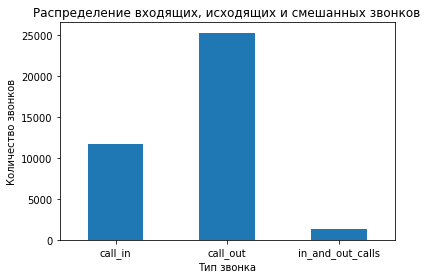

In [23]:
call_type_pivot.sum().plot(kind='bar')
plt.title('Распределение входящих, исходящих и смешанных звонков')
plt.xlabel('Тип звонка')
plt.xticks(rotation=0)
plt.ylabel('Количество звонков')

Итак, исходящих звонков больше всего, а количество в смешанном типе минимальное.

#### Длительность исследуемого периода
Изучим даты, за которые у нас есть данные.

In [24]:
# Выясним минимальную и максимальную дату исследуемого периода
first_date = df['date'].min()
last_date = df['date'].max()

# Посчитаем величину периода
diff = last_date - first_date

print('Исследуемый период: с %s до %s, количество дней: %s.' % (first_date, last_date, diff))

Исследуемый период: с 2019-08-02 00:00:00 до 2019-11-28 00:00:00, количество дней: 118 days 00:00:00.


Значит, у нас данные за примерно 3 месяца наблюдений.<br>

Теперь вытащим отдельно дни недели из столбца 'date' и проанализируем количество звонков по дням.

In [25]:
df['day'] = pd.DatetimeIndex(df['date']).day
df['weekday'] = df['date'].dt.day_name()
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,day,weekday
0,166377,2019-08-05,out,True,880022,True,3,0,5,B,2019-08-01,5,Monday
1,166377,2019-08-05,out,True,880020,True,1,0,1,B,2019-08-01,5,Monday
2,166377,2019-08-05,out,True,880020,False,1,10,18,B,2019-08-01,5,Monday
3,166377,2019-08-05,out,False,880022,True,3,0,25,B,2019-08-01,5,Monday
4,166377,2019-08-05,out,False,880020,False,2,3,29,B,2019-08-01,5,Monday


<a id='calls_by_weekday'></a>
Построим график распределения звонков по дням недели, заодно добавим разбивку на входящие и исходящие

Text(0, 0.5, 'Количество звонков')

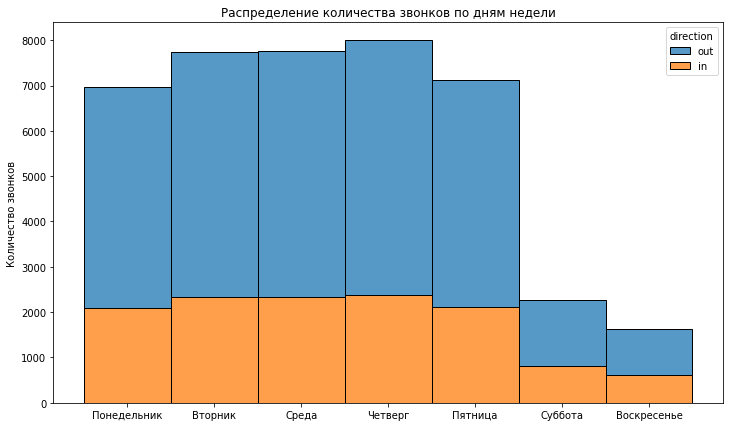

In [26]:
plt.figure(figsize=(12, 7))
ax = sns.histplot(df, x='weekday', hue='direction', multiple='stack')
plt.xticks(['Sunday', 'Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday','Saturday'],
           ['Воскресенье', 'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница','Суббота'])
ax.axes.set_title('Распределение количества звонков по дням недели')
ax.set_xlabel('')
ax.set_ylabel('Количество звонков')

Пиковый результат - по четвергам, а в выходные звонков в разы меньше.<br>
Как мы уже знаем, исходящих звонков в целом больше, чем входящих. Теперь видно, что это справедливо для каждого дня недели.

#### Количество операторов у клиентов
Определим среднее и максимальное значения

In [28]:
# Посчитаем количество клиентов
df['user_id'].nunique()

290

In [29]:
# Посчитаем количество операторов
df['operator_id'].nunique()

1092

В нашем датасете 290 уникальных значений клиентов и 1092 - операторов.

In [30]:
# Посмотрим статистику 
df.groupby('user_id')['operator_id'].nunique().describe()

count   290.00
mean      3.77
std       5.72
min       1.00
25%       1.00
50%       2.00
75%       4.00
max      50.00
Name: operator_id, dtype: float64

В среднем у каждого клиента по 3.8 оператора. <br>
Максимальное значение - 50 операторов на клиента, многовато.

Посмотрим на диаграмму размаха

<AxesSubplot:>

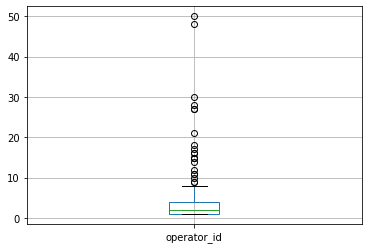

In [31]:
operators_count = df.groupby('user_id')['operator_id'].nunique().reset_index()
operators_count.boxplot(column='operator_id')

(0.0, 9.0)

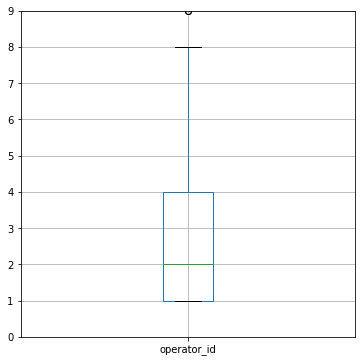

In [32]:
# Увеличим масштаб
operators_count.boxplot(column='operator_id', figsize=(6,6))
plt.ylim(0,9)

In [33]:
# Избавимся от выбросов
operators_count_clean = operators_count.query('operator_id <= operator_id.quantile(0.95)')
operators_count_clean['operator_id'].describe()

count   275.00
mean      2.67
std       2.10
min       1.00
25%       1.00
50%       2.00
75%       4.00
max      12.00
Name: operator_id, dtype: float64

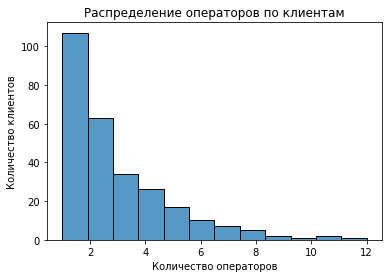

In [34]:
# Отобразим на графике
sns.histplot(operators_count_clean['operator_id'])
plt.title('Распределение операторов по клиентам')
plt.xlabel('Количество операторов')
plt.ylabel('Количество клиентов')

plt.show()

В итоге видим:

- у большинства клиентов от 1 - 2 оператора.
- максимальное количество операторов после удаления выбросов - 12.

#### Вывод по исследовательскому анализу данных

- Исходящих звонков больше всего, затем по количеству идут входящие звонки, а в смешанном типе их минимум,
- Больше всего звонков по четвергам, в выходные звонков в разы меньше,
- У большинства клиентов 1 - 2 оператора, а максимальное количество операторов (после очистки от выбросов) - 12.

### Определение неэффективных операторов

#### Первый критерий - количество пропущенных входящих звонков

In [35]:
# Вспомним, как выглядят данные нашего объединённого датафрейма
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,day,weekday
0,166377,2019-08-05,out,True,880022,True,3,0,5,B,2019-08-01,5,Monday
1,166377,2019-08-05,out,True,880020,True,1,0,1,B,2019-08-01,5,Monday
2,166377,2019-08-05,out,True,880020,False,1,10,18,B,2019-08-01,5,Monday
3,166377,2019-08-05,out,False,880022,True,3,0,25,B,2019-08-01,5,Monday
4,166377,2019-08-05,out,False,880020,False,2,3,29,B,2019-08-01,5,Monday


In [37]:
# Сгруппируем принятые и пропущенные звонки
missed_or_not_group = df.groupby('is_missed_call', as_index=False)['calls_count'].agg('sum')

# Добавим в группировку % от общего числа звонков
missed_or_not_group['part_of_total, %'] = missed_or_not_group['calls_count'] / df['calls_count'].sum()*100

missed_or_not_group

,is_missed_call,calls_count,"part_of_total, %"
0,False,429767,61.21
1,True,272318,38.79


В датасете 61% принятых звонков и 39% пропущенных.

Далее для каждого оператора посчитаем среднее количество пропущенных за день

In [47]:
# Создадим новый промежуточный датасет с только входящими звонками и без внутренних вызовов между операторами
calls_in_no_int = df[(df['direction']=='in') & (df['internal']==0)]

calls_in_no_int.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,day,weekday
21,166377,2019-08-12,in,False,880028,False,1,407,411,B,2019-08-01,12,Monday
26,166377,2019-08-13,in,False,880028,False,1,88,102,B,2019-08-01,13,Tuesday
29,166377,2019-08-14,in,False,880026,False,2,197,218,B,2019-08-01,14,Wednesday
30,166377,2019-08-14,in,False,880028,False,1,33,37,B,2019-08-01,14,Wednesday
38,166377,2019-08-15,in,False,880028,False,1,23,27,B,2019-08-01,15,Thursday


In [48]:
# Создадим промежуточную группировку с суммой всех пропущенных по каждому оператору
missed_calls_count_perc = calls_in_no_int.groupby(['operator_id'])['calls_count'].sum().reset_index().sort_values(by='calls_count', ascending=False)

# Добавим в группировку % от общей суммы всех типов звонков
missed_calls_count_perc['percent_of_missed_calls'] = missed_calls_count_perc['calls_count'] / calls_in_no_int['calls_count'].sum()*1000

missed_calls_count_perc.head()

,operator_id,calls_count,percent_of_missed_calls
285,913938,4766,51.22
659,952948,3540,38.04
286,913942,2467,26.51
76,893804,2427,26.08
355,921318,2318,24.91


In [49]:
missed_calls_count_perc['percent_of_missed_calls'].describe()

count   738.00
mean      1.36
std       3.86
min       0.01
25%       0.04
50%       0.19
75%       0.85
max      51.22
Name: percent_of_missed_calls, dtype: float64

Получается, что 75% операторов пропускают не более 0.8 % от всех звонков за день.<br>
Примем этот показатель за границу эффективности.

Будем считать так:
 - от 0 до 1% пропущенных звонков - высокая эффективность,
 - от 1% до 10% пропущенных звонков - средняя эффективность,
 - начиная с 10% пропущенных - низкая эффективность.

In [50]:
# Создадим функцию, определяющую эффективность оператора
def eff_rate_func_calls_missed(percent_of_missed_calls):
    if percent_of_missed_calls < 1:
        return 'Высокая эффективность'
    elif percent_of_missed_calls > 10:
        return 'Низкая эффективность'
    else:
        return 'Средняя эффективность'


missed_calls_count_perc['efficiency_rate_by_calls_missed'] = missed_calls_count_perc['percent_of_missed_calls'].apply(eff_rate_func_calls_missed)

missed_calls_count_perc.head()

,operator_id,calls_count,percent_of_missed_calls,efficiency_rate_by_calls_missed
285,913938,4766,51.22,Низкая эффективность
659,952948,3540,38.04,Низкая эффективность
286,913942,2467,26.51,Низкая эффективность
76,893804,2427,26.08,Низкая эффективность
355,921318,2318,24.91,Низкая эффективность


In [51]:
# И, наконец, финальный рейтинг: сгруппируем по операторам среднее количество исходящих вызовов
missed_calls_count_perc_rate = missed_calls_count_perc.groupby(
    ['efficiency_rate_by_calls_missed']
)['operator_id'].count().reset_index().sort_values(
    by='operator_id',
    ascending=False
)
# Добавим в группировку % от общего числа звонков и подправим названия столбцов
missed_calls_count_perc_rate['part_of_total, %'] = missed_calls_count_perc_rate['operator_id'] / missed_calls_count_perc['operator_id'].count()*100

missed_calls_count_perc_rate

,efficiency_rate_by_calls_missed,operator_id,"part_of_total, %"
0,Высокая эффективность,563,76.29
2,Средняя эффективность,154,20.87
1,Низкая эффективность,21,2.85


#### Второй критерий - длительность ожидания ответа

Для расчёта длительности ожидания нам понадобятся 2 новых столбца: 
 - время ожидания (разница между общей длительностью звонка 'total_call_duration' и длительностью разговора 'call_duration'),
 - среднее время ожидания.

In [54]:
# Создаём новые столбцы
df['waiting_time'] = df['total_call_duration'] - df['call_duration']
df['avg_wait_time_per_call'] = df['waiting_time'] / df['calls_count']

# Упорядочим столбцы по смыслу данных, чтобы все созданные нами столбцы были рядом с исходными:
# дни недели рядом с датой, время ожидания - рядом с длительностью звонка
df = df[[
 'user_id',  
 'date',
 'day',
 'weekday',
 'direction',
 'internal',
 'operator_id',
 'is_missed_call',
 'calls_count',
 'call_duration',
 'total_call_duration',
 'waiting_time',
 'avg_wait_time_per_call',
 'tariff_plan',  
 'date_start'
]]

df.head()

,user_id,date,day,weekday,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,avg_wait_time_per_call,tariff_plan,date_start
0,166377,2019-08-05,5,Monday,out,True,880022,True,3,0,5,5,1.67,B,2019-08-01
1,166377,2019-08-05,5,Monday,out,True,880020,True,1,0,1,1,1.00,B,2019-08-01
2,166377,2019-08-05,5,Monday,out,True,880020,False,1,10,18,8,8.00,B,2019-08-01
3,166377,2019-08-05,5,Monday,out,False,880022,True,3,0,25,25,8.33,B,2019-08-01
4,166377,2019-08-05,5,Monday,out,False,880020,False,2,3,29,26,13.00,B,2019-08-01


Красота.

In [55]:
# Создадим новый промежуточный датасет с только входящими звонками
calls_in = df[df['direction'] == "in"]

# Уберём внутренние звонки между операторами
calls_in_no_internal = calls_in[calls_in['internal'] == 0]

calls_in_no_internal.sample(5)

,user_id,date,day,weekday,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,avg_wait_time_per_call,tariff_plan,date_start
38348,168190,2019-11-01,1,Friday,in,False,952982,False,1,5,6,1,1.00,C,2019-10-16
16846,167053,2019-09-05,5,Thursday,in,False,903292,False,9,1668,1777,109,12.11,C,2019-08-29
12620,166916,2019-10-29,29,Tuesday,in,False,906404,False,11,1327,1635,308,28.00,A,2019-08-23
30623,167792,2019-10-11,11,Friday,in,False,933832,False,2,52,78,26,13.00,C,2019-09-30
36439,168187,2019-10-24,24,Thursday,in,False,937736,False,8,779,848,69,8.62,A,2019-10-16


In [64]:
# Создадим промежуточную группировку с суммой среднего времени ожидания по каждому оператору
calls_in_no_internal_long_wait = calls_in_no_internal.groupby(['operator_id'])['avg_wait_time_per_call'].mean().reset_index().sort_values(by='avg_wait_time_per_call', ascending=False)

calls_in_no_internal_long_wait.head()

,operator_id,avg_wait_time_per_call
197,905842,115.50
308,917680,100.00
121,899900,71.00
223,907174,65.19
700,960296,63.00


In [65]:
calls_in_no_internal_long_wait['avg_wait_time_per_call'].describe()

count   738.00
mean     17.94
std      12.48
min       0.68
25%       9.49
50%      14.69
75%      22.73
max     115.50
Name: avg_wait_time_per_call, dtype: float64

Выводы по статистике:
- до 25% операторов показывают результат в 9.5 секунд
- максимальное среднее значение - 115 секунд (то есть почти 2 минуты)
 
Значения вполне реальные. <br>

Теперь посмотрим на графики:

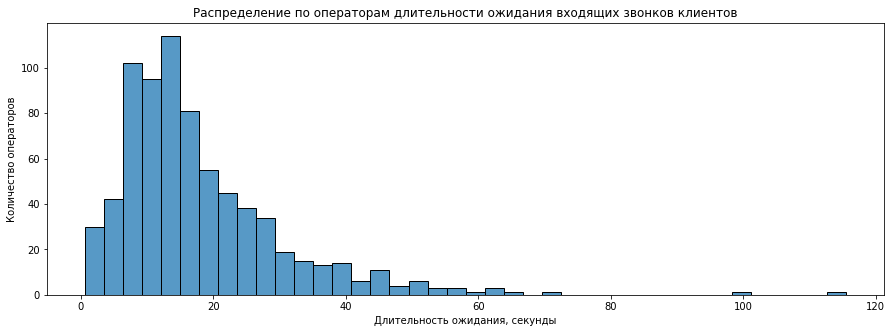

In [66]:
plt.figure(figsize=(15, 5))
sns.histplot(calls_in_no_internal_long_wait['avg_wait_time_per_call'])
plt.title('Распределение по операторам длительности ожидания входящих звонков клиентов')
plt.xlabel('Длительность ожидания, секунды')
plt.ylabel('Количество операторов')

plt.show()

Снова воспользуемся данными статистики, будем отталкиваться от среднего времени ожидания 25% операторов 9.5 секунд - это наши лучшие операторы, только округлим до 10 сек.<br>
Будем считать так:
 - от 0 до 10 секунд - высокая эффективность,
 - от 10 до 20 секунд - средняя эффективность (здесь основная масса результатов),
 - начиная с 20 секунд ожидания - низкая эффективность.

In [67]:
# Создадим функцию, определяющую эффективность оператора 
def eff_rate_func_wait_time(avg_wait_time_per_call):
    if avg_wait_time_per_call < 10:
        return 'Высокая эффективность (до 10 сек. ожидания)'
    elif avg_wait_time_per_call > 20:
        return 'Низкая эффективность (более 20 сек. ожидания)'
    else:
        return 'Средняя эффективность (10-20 сек. ожидания)'


calls_in_no_internal_long_wait['efficiency_rate_by_wait_time'] = calls_in_no_internal_long_wait['avg_wait_time_per_call'].apply(eff_rate_func_wait_time)

In [68]:
# И, наконец, финальный рейтинг: сгруппируем по операторам среднее количество исходящих вызовов
calls_in_no_internal_long_wait_rate = calls_in_no_internal_long_wait.groupby(
    ['efficiency_rate_by_wait_time']
)['operator_id'].count().reset_index().sort_values(
    by='operator_id',
    ascending=False
)
# Добавим в группировку % от общего числа звонков и подправим названия столбцов
calls_in_no_internal_long_wait_rate['part_of_total, %'] = calls_in_no_internal_long_wait_rate['operator_id'] / calls_in_no_internal_long_wait['operator_id'].count()*100

calls_in_no_internal_long_wait_rate

,efficiency_rate_by_wait_time,operator_id,"part_of_total, %"
2,Средняя эффективность (10-20 сек. ожидания),314,42.55
1,Низкая эффективность (более 20 сек. ожидания),229,31.03
0,Высокая эффективность (до 10 сек. ожидания),195,26.42


Низкоэффективных операторов 31%, а высокую эффективность показывают только 26% операторов.

#### Третий критерий - количество исходящих вызовов

In [80]:
# Создадим промежуточную группировку с суммой всех пропущенных по каждому оператору
calls_out_by_operator = calls_out_no_int.groupby(['operator_id'])['calls_count'].mean().reset_index().sort_values('calls_count', ascending = False)

calls_out_by_operator.head()

,operator_id,calls_count
429,925922,426.15
240,908640,374.58
23,885890,370.92
447,929428,365.45
22,885876,305.94


In [81]:
calls_out_by_operator['calls_count'].describe()

count   833.00
mean     16.13
std      34.82
min       1.00
25%       2.00
50%       4.02
75%      15.93
max     426.15
Name: calls_count, dtype: float64

426 звонков в день - многовато, очистим данные:<br>

count   791.00
mean     10.73
std      14.72
min       1.00
25%       1.89
50%       3.65
75%      13.05
max      66.72
Name: calls_count, dtype: float64


<AxesSubplot:>

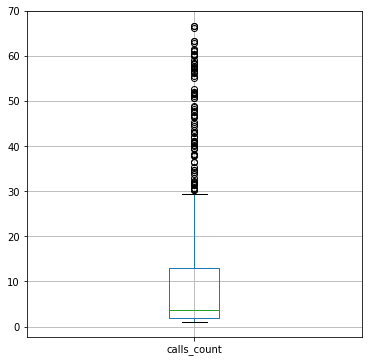

In [82]:
calls_out_by_operator_clean = calls_out_by_operator.query('calls_count <= calls_count.quantile(0.95)')

print(calls_out_by_operator_clean['calls_count'].describe())
calls_out_by_operator_clean.boxplot(column='calls_count', figsize=(6,6))

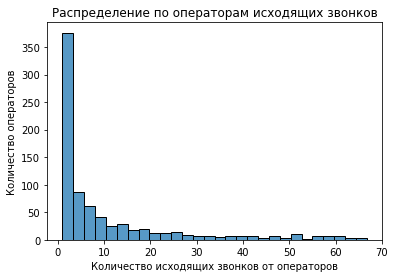

In [83]:
# Наглядная гистограмма
sns.histplot(calls_out_by_operator_clean['calls_count'])
plt.title('Распределение по операторам исходящих звонков')
plt.xlabel('Количество исходящих звонков от операторов')
plt.ylabel('Количество операторов')

plt.show()

По статистике среднее значение - 10 звонков.<br>
75% операторов совершают в среднем 13 звонков в день, но для оператора колл-центра это не так и много.<br>
 
Будем считать, что:
 - более 30 исходящих звонков - высокая эффективность (граница начала выбросов),
 - от 15 до 30 звонков - средняя эффективность,
 - менее 15 - низкая эффективность.

In [84]:
# Создадим функцию, определяющую эффективность оператора
def eff_rate_func_calls_out(calls_count):
    if calls_count > 30:
        return 'Высокая эффективность (более 30 исходящих)'
    elif calls_count < 15:
        return 'Низкая эффективность (менее 15 исходящих)'
    else:
        return 'Средняя эффективность (15 - 30 звонков)'


calls_out_by_operator_clean['efficiency_rate_by_calls_out'] = calls_out_by_operator_clean['calls_count'].apply(eff_rate_func_calls_out)

In [85]:
# И, наконец, финальный рейтинг: сгруппируем по операторам среднее количество исходящих вызовов
calls_out_by_operator_clean_rate = calls_out_by_operator_clean.groupby(
    ['efficiency_rate_by_calls_out']
)['operator_id'].count().reset_index().sort_values(
    by='operator_id',
    ascending=False
)
# Добавим в группировку % от общего числа звонков и подправим названия столбцов
calls_out_by_operator_clean_rate['part_of_total, %'] = calls_out_by_operator_clean_rate['operator_id'] / calls_out_by_operator_clean['operator_id'].count()*100

calls_out_by_operator_clean_rate

,efficiency_rate_by_calls_out,operator_id,"part_of_total, %"
1,Низкая эффективность (менее 15 исходящих),617,78.00
0,Высокая эффективность (более 30 исходящих),88,11.13
2,Средняя эффективность (15 - 30 звонков),86,10.87


В итоге низкоэффективных операторов (совершающих менее 15 исходящих вызовов) больше всех: 78%.<br>
Средней и высокой эффективности примерно поровну, около 11%.

#### Вывод по неэффективности операторов

Для определения эффективности операторов мы разделили их на 3 категории - высокая, средняя и низкая эффективность - по критериям:

 - Пропущенные входящие звонки:
    - Больше всего высокоэффективных - почти 76%,
    - Неэффективных операторов - 3%.
    <br>
    
    
 - Длительность ожидания ответа 
    - Низкоэффективных операторов 31%, 
    - Высокую эффективность показывают только 26% операторов.
    <br>
    
    
 - Количество исходящих - для "обзванивающих" колл-центров
    - Низкоэффективных операторов (совершающих менее 15 исходящих вызовов) больше всех: 78%.<br>
    - Средней и высокой эффективности примерно поровну, около 11%.


### Проверка гипотез

#### Гипотеза о зависимости времени ожидания звонка от тарифного плана

 - H0 - нет статистически значимой разницы между тарифами по времени ожидания ответа на входящий звонок,

 - H1 - существует статистически значимая разница между разными тарифами по времени ожидания ответа на входящий звонок.

In [89]:
sample_A = df[df['tariff_plan'] == 'A']['avg_wait_time_per_call']
sample_B = df[df['tariff_plan'] == 'B']['avg_wait_time_per_call']
sample_C = df[df['tariff_plan'] == 'C']['avg_wait_time_per_call']

In [90]:
# Создадим функцию для теста mannwhitneyu

def mannwhitneyu_test(a, b, c):
    alpha = 0.05
    results_AB_mannwhitneyu = st.mannwhitneyu(sample_A, sample_B)
    results_BC_mannwhitneyu = st.mannwhitneyu(sample_B, sample_C)
    results_AC_mannwhitneyu = st.mannwhitneyu(sample_A, sample_C)
    bonferroni_alpha = alpha / 3  # произведено три сравнения
    print('p-значение для сравнения групп А и B: ', results_AB_mannwhitneyu.pvalue)
    print('p-значение для сравнения групп B и C: ', results_BC_mannwhitneyu.pvalue)
    print('p-значение для сравнения групп А и C: ', results_AC_mannwhitneyu.pvalue)
    if (results_AB_mannwhitneyu.pvalue < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу для сравнения тарифов А и B: разница статистически значима")
    else:
        print("Не получилось отвергнуть нулевую гипотезу для сравнения тарифов А и B")

    if (results_BC_mannwhitneyu.pvalue < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу для сравнения тарифов B и C: разница статистически значима")
    else:
        print("Не получилось отвергнуть нулевую гипотезу для сравнения тарифов B и C")

    if (results_AC_mannwhitneyu.pvalue < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу для сравнения тарифов А и C: разница статистически значима")
    else:
        print("Не получилось отвергнуть нулевую гипотезу для сравнения тарифов А и C")

In [91]:
mannwhitneyu_test(sample_A, sample_B, sample_C)

p-значение для сравнения групп А и B:  3.986479493245058e-07
p-значение для сравнения групп B и C:  7.416345758951299e-27
p-значение для сравнения групп А и C:  2.469395425918094e-57
Отвергаем нулевую гипотезу для сравнения тарифов А и B: разница статистически значима
Отвергаем нулевую гипотезу для сравнения тарифов B и C: разница статистически значима
Отвергаем нулевую гипотезу для сравнения тарифов А и C: разница статистически значима


Гипотеза H0 опровергнута: есть статистические значимые различия между временем ожидания звонка по тарифам A, B и С.

#### Гипотеза о зависимости количества звонков от дня недели

Как мы знаем из [графика распределения звонков по дням недели](#calls_by_weekday), больше всего звонков - по четвергам, а меньше всего - по воскресеньям.<br>

Можно проверить еще пару гипотез о принятых вызовах: когда загрузка колл-центров максимальная - по четвергам, и когда минимальная - по воскресеньям.

***Для наиболее загуженного дня недели - четверга***

 - Н0: Количество принятых звонков операторами в четверг такое же, как и в остальные дни,

 - Н1: Количество принятых звонков операторами в четверг и в остальные дни отличаются.

In [92]:
alpha = 0.05

results = st.mannwhitneyu(
    df.query('(weekday=="Thursday") and (direction == "in") and (is_missed_call == False)')['calls_count'], 
    df.query('(weekday!="Thursday") and (direction == "in") and (is_missed_call == False)')['calls_count'],
    )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.9458972647803612
Не получилось отвергнуть нулевую гипотезу


***Для наименее загуженного дня недели - воскресенья***

 - Н0: Количество принятых звонков операторами в четверг такое же, как и в остальные дни,

 - Н1: Количество принятых звонков операторами в четверг и в остальные дни отличаются.

In [93]:
alpha = 0.05

results = st.mannwhitneyu(
    df.query('(weekday=="Sunday") and (direction == "in") and (is_missed_call == False)')['calls_count'], 
    df.query('(weekday!="Sunday") and (direction == "in") and (is_missed_call == False)')['calls_count'],
    )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.702208972327239
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза не отвергнута в обоих случаях.<br>
Другими словами, есть статистическая вероятность, что количество принятых звонков операторами не отличается ни в четверг, ни в воскресенье, ни в остальные дни.

### Общий вывод

**Ознакомившись с исходными файлами для анализа мы сначала занялись предобработкой данных:**<br>

 - В файле 'clients' поменяли тип данных на 'дату' в колонке 'date_start'.<br>

 - В файле 'dataset':

   - удалили строки с пропусками,
   - исправили типы данных, где необходимо,
   - удалили дубликаты.

**После исследовательского анализа узнали, что:**

- Исходящих звонков больше всего, затем по количеству идут входящие звонки, а в смешанном типе их минимум,
- Больше всего звонков по четвергам, в выходные звонков в разы меньше,
- У большинства клиентов 1 - 2 оператора, а максимальное количество операторов (после очистки от выбросов) - 12.

**Для определения эффективности операторов мы разделили их на 3 категории** - высокая, средняя и низкая эффективность - по критериям:

 - Пропущенные входящие звонки:
    - Больше всего высокоэффективных - почти 76%,
    - Неэффективных операторов - 3%.
    <br>
    
    
 - Длительность ожидания ответа 
    - Низкоэффективных операторов 31%, 
    - Высокую эффективность показывают только 26% операторов.
    <br>
    
    
 - Количество исходящих - для "обзванивающих" колл-центров
    - Низкоэффективных операторов (совершающих менее 15 исходящих вызовов) больше всех: 78%.<br>
    - Средней и высокой эффективности примерно поровну, около 11%.

**Кроме того, выдвинули пару гипотез:**
 - О зависимости времени ожидания звонка от тарифного плана: есть статистические значимые различия между временем ожидания звонка по тарифам A, B и С.
 <br>
 
 - О зависимости количества звонков от дня недели: есть статистическая вероятность, что количество принятых звонков операторами не отличается ни в четверг, ни в воскресенье, ни в остальные дни недели.

**Презентация по проекту**

https://disk.yandex.ru/i/SFVPfwdqCt21bA